# Libraries


In [5]:
import pandas as pd
pd.set_option('display.max_colwidth',1)
pd.set_option("display.max_columns", None)
import re
import numpy as np
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

In [6]:
df_apart_paris=pd.read_csv('df_apart_paris.csv')


C:\Users\khale\AppData\Local\Temp\ipykernel_17548\3650075201.py:1: DtypeWarning: Columns (15,25,27,29,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_apart_paris=pd.read_csv('df_apart_paris.csv')


#Cleaning Data

In [7]:
def missing_values_assessment(df):
    nan_values = df.isnull().sum().sum()
    print('Nombre d\'observations: {:,}'.format(len(df.index)))
    print('Nombre de valeurs: {:,}'.format(df.size))
    print('Valeurs manquantes: {:,}'.format(nan_values))
    print('Qualité des données: {}%'.format(100-round((nan_values/df.size)*100,2)))
    print('Type de données:\n {}%'.format(df.dtypes.value_counts()))
    analysis = {'Manquant': df.isnull().sum(),
                'Manquant %':round((df.isnull().sum()/len(df))*100, 2),
                'Type':df.dtypes
               }
    return pd.DataFrame(analysis)
missing_values_assessment(df_apart_paris).sort_values('Manquant %', ascending=False)

Nombre d'observations: 203,499
Nombre de valeurs: 8,953,956
Valeurs manquantes: 4,388,710
Qualité des données: 50.99%
Type de données:
 object     20
float64    18
int64      6 
dtype: int64%


,Manquant,Manquant %,Type
Identifiant local,203499,100.00,float64
Reference document,203499,100.00,float64
1 Articles CGI,203499,100.00,float64
2 Articles CGI,203499,100.00,float64
3 Articles CGI,203499,100.00,float64
4 Articles CGI,203499,100.00,float64
5 Articles CGI,203499,100.00,float64
No Volume,203499,100.00,float64
Code service sages,203499,100.00,float64
Prefixe de section,203499,100.00,float64


In [8]:
initial_length = len(df_apart_paris)
df_apart_paris.drop_duplicates(inplace=True)
print("deleting {} duplicates from data in {}".format(initial_length-len(df_apart_paris),df_apart_paris['Code departement'][0]))

df_apart_paris=df_apart_paris[(df_apart_paris['No disposition']==1)&(df_apart_paris['Nature mutation']=='Vente')]#so we dont risk having other types like "MAISON" and selecting only the sellings


deleting 0 duplicates from data in 75


In [9]:
#drop columns with 100% for missing values    
#drop 'Unnamed: 0','Type local','Code type local','Code departement'
#drop'Commune' it is not needed since we have code commune column already as type int

def drop_columns_rows(df):
    perc = 100.0 # Like N %
    min_count =  int(((100-perc)/100)*len(df) + 1)
    df = df.dropna( axis=1, 
                    thresh=min_count)
    df = df[df['Valeur fonciere'].notna()]
    df = df.drop(['Unnamed: 0', 'Type local','Code type local','Code departement','Commune','B/T/Q','Code voie','Nature mutation'], axis=1)
    return df
df_apart_paris=drop_columns_rows(df_apart_paris)

In [10]:
def clean_data(df):
    for k in df[['Valeur fonciere','1er lot','Surface Carrez du 1er lot','2eme lot','Surface Carrez du 2eme lot','3eme lot','Surface Carrez du 3eme lot','Surface Carrez du 4eme lot','Surface Carrez du 5eme lot']]: 
        df[f'{k}'] = df[f'{k}'].replace(',','.', regex=True)
        df[f'{k}'] = df[f'{k}'].replace('[a-zA-Z]+','', regex=True)

    df=df.astype({'Valeur fonciere': 'float64','1er lot':'float64',
               'Surface Carrez du 1er lot':'float64','2eme lot':'float64','Surface Carrez du 2eme lot':'float64',
               '3eme lot':'float64','Surface Carrez du 3eme lot':'float64','Surface Carrez du 4eme lot':'float64','Surface Carrez du 5eme lot':'float64'},errors='raise')
    
    return df
df_apart_paris=clean_data(df_apart_paris)

In [11]:
def cleaning_2(df):
    df['surface_des_lots']=df['Surface Carrez du 1er lot'].fillna(0)+df['Surface Carrez du 2eme lot'].fillna(0)+df['Surface Carrez du 3eme lot'].fillna(0)+df['Surface Carrez du 4eme lot'].fillna(0)+df['Surface Carrez du 5eme lot'].fillna(0)
    #df['surface_des_lots_number']=df['1er lot']+df['2eme lot']+df['3eme lot']+df['4eme lot']+df['5eme lot']
    #df['surface_des_lots_final']=df['surface_des_lots']+df['surface_des_lots_number']
    df=df.drop(columns=['1er lot','2eme lot','3eme lot','4eme lot','5eme lot','Surface Carrez du 1er lot','Surface Carrez du 2eme lot','Surface Carrez du 3eme lot','Surface Carrez du 4eme lot','Surface Carrez du 5eme lot'],axis=1)
    return df
df_apart_paris=cleaning_2(df_apart_paris)

In [12]:
def fill_nan_values(df):    
    for k in df:
        if df[f'{k}'].dtypes=='int64' or df[f'{k}'].dtypes=='float64' :
            df[f'{k}'].fillna(0, inplace=True)
        elif df[f'{k}'].dtypes=='object':
            df[f'{k}'].fillna('', inplace=True)
    return df
df_apart_paris=fill_nan_values(df_apart_paris)

# time serie column

In [13]:
#sort data and drop duplicate
df_apart_paris['Date mutation'] = pd.to_datetime(df_apart_paris['Date mutation'], format = '%d/%m/%Y', errors = 'raise')
df_apart_paris = df_apart_paris.sort_values(by='Date mutation', ignore_index=True)

array([[<Axes: title={'center': 'Date mutation'}>]], dtype=object)

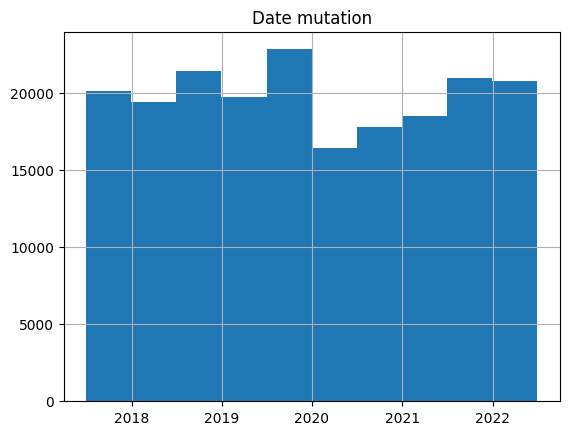

In [14]:
df_apart_paris.hist(column='Date mutation')

In [15]:
def creat_coulmn(df):
    df['year'] = df['Date mutation'].dt.year
    df['month'] = df['Date mutation'].dt.month
    #df['converted_seconds'] = df['Date mutation'] - df['Date mutation'][0]
    #df['converted_seconds']=df['converted_seconds'].dt.total_seconds()
    return df

#season column
def find_season(month):
    season_month_north = {
            12:'T4', 1:'T1', 2:'T1',
            3:'T1', 4:'T2', 5:'T2',
            6:'T2', 7:'T3', 8:'T3',
            9:'T3', 10:'T4', 11:'T4'}
    return season_month_north.get(month)
def get_season(df):
    season_list = []
    for month in df['month']:
        season = find_season(month)
        season_list.append(season)
    df['Season'] = season_list
    return df
    
    
df_apart_paris=creat_coulmn(df_apart_paris)
df_apart_paris=get_season(df_apart_paris)

## Create a column with: Rescaled price with the inflation rate

In [16]:
#rescale the prices column to the prices in third term 2022
def rescale_price(df):
    df['Valeur_fonciere_scaled']=np.nan
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T3')&(df['year']==2017), df['Valeur fonciere']*1.256580117, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T4')&(df['year']==2017), df['Valeur fonciere']*1.2410327, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T1')&(df['year']==2018), df['Valeur fonciere']*1.22989, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T2')&(df['year']==2018), df['Valeur fonciere']*1.2233757, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T3')&(df['year']==2018), df['Valeur fonciere']*1.21526, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T4')&(df['year']==2018), df['Valeur fonciere']*1.200225, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T1')&(df['year']==2019), df['Valeur fonciere']*1.1848, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T2')&(df['year']==2019), df['Valeur fonciere']*1.17293, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T3')&(df['year']==2019), df['Valeur fonciere']*1.168520418, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T4')&(df['year']==2019), df['Valeur fonciere']*1.13981, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T1')&(df['year']==2020), df['Valeur fonciere']*1.1136017, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T2')&(df['year']==2020), df['Valeur fonciere']*1.096205, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T3')&(df['year']==2020), df['Valeur fonciere']*1.096173, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T4')&(df['year']==2020), df['Valeur fonciere']*1.071254, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T1')&(df['year']==2021), df['Valeur fonciere']*1.059564, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T2')&(df['year']==2021), df['Valeur fonciere']*1.045, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T3')&(df['year']==2021), df['Valeur fonciere']*1.041, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T4')&(df['year']==2021), df['Valeur fonciere']*1.02414, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T1')&(df['year']==2022), df['Valeur fonciere']*1.012, inplace=True)
    df['Valeur_fonciere_scaled'].mask((df['Season'] == 'T2')&(df['year']==2022), df['Valeur fonciere'], inplace=True)
    return df
df_apart_paris=rescale_price(df_apart_paris)

In [17]:
df_apart_paris['price_in_m_2']=df_apart_paris['Valeur fonciere'].div(df_apart_paris['Surface reelle bati'].values)
df_apart_paris['price_in_m_2_scaled']=df_apart_paris['Valeur_fonciere_scaled'].div(df_apart_paris['Surface reelle bati'].values)

# ecode categorical columns:

In [18]:
def encode_ctg(df):
    categorical_features_not_encoded=['No voie','Type de voie','Voie','Section','Nature culture','Nature culture speciale','Season']
    #5,392,25,3388,185,2,1,4
    enc = OrdinalEncoder()
    for k in categorical_features_not_encoded:
        df_apart_paris[[f'{k}']]=enc.fit_transform(df_apart_paris[[f'{k}']])
    return df
    
df_apart_paris=encode_ctg(df_apart_paris)

# Business Rules and outliers detection

In [19]:
df_apart_paris=df_apart_paris[(df_apart_paris['Surface reelle bati']<400)&(df_apart_paris['Surface reelle bati']>9)]
#df_apart_paris=df_apart_paris[(df_apart_paris['Valeur_fonciere_scaled']<1200000)]
#df_apart_paris=df_apart_paris[(df_apart_paris['surface_des_lots']<500)]
df_apart_paris=df_apart_paris[(df_apart_paris['Nombre de lots']<6)]
df_apart_paris=df_apart_paris.drop(df_apart_paris[(df_apart_paris['surface_des_lots']==0) & (df_apart_paris['Nombre de lots']!=0)].index)
df_apart_paris=df_apart_paris[(df_apart_paris['price_in_m_2_scaled']<18000)&(df_apart_paris['price_in_m_2_scaled']>5000)]

# Correlation

high correlation btw the surface,number of pieces and the price.
high correlation btw the surface and the number of pieces.



In [20]:
corr = df_apart_paris.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\khale\AppData\Local\Temp\ipykernel_17548\1798875449.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_apart_paris.corr()
c:\Users\khale\anaconda3\envs\house_prediction\lib\site-packages\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\khale\anaconda3\envs\house_prediction\lib\site-packages\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,No disposition,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Code commune,Section,No plan,Nombre de lots,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,surface_des_lots,year,month,Season,Valeur_fonciere_scaled,price_in_m_2,price_in_m_2_scaled
No disposition,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Valeur fonciere,nan,1.000000,-0.018221,-0.107479,0.031217,-0.121520,-0.121520,0.007269,-0.051781,0.239561,0.931110,0.787208,-0.007261,nan,-0.011450,0.496438,0.090256,-0.014375,-0.014086,0.992072,0.401162,0.384686
No voie,nan,-0.018221,1.000000,-0.135913,-0.006829,0.025314,0.025314,-0.015549,-0.040151,-0.001559,0.003212,0.008853,0.019740,nan,0.024128,0.002508,-0.001944,-0.001918,-0.002208,-0.018279,-0.060788,-0.062650
Type de voie,nan,-0.107479,-0.135913,1.000000,-0.046407,-0.021220,-0.021220,-0.037892,0.095242,-0.012580,-0.122287,-0.094745,0.018755,nan,0.011273,-0.063212,0.001656,0.000540,-0.000034,-0.108209,0.010328,0.010181
Voie,nan,0.031217,-0.006829,-0.046407,1.000000,-0.023605,-0.023605,-0.051182,0.023579,-0.003796,0.023034,0.016862,-0.015446,nan,-0.023007,0.012917,-0.000812,0.003212,0.002306,0.031271,0.033255,0.034782
Code postal,nan,-0.121520,0.025314,-0.021220,-0.023605,1.000000,1.000000,0.324326,-0.001028,0.039654,-0.030843,-0.000754,0.023282,nan,0.027682,-0.011244,-0.003378,0.001474,0.002486,-0.121411,-0.312017,-0.324312
Code commune,nan,-0.121520,0.025314,-0.021220,-0.023605,1.000000,1.000000,0.324326,-0.001028,0.039654,-0.030843,-0.000754,0.023282,nan,0.027682,-0.011244,-0.003378,0.001474,0.002486,-0.121411,-0.312017,-0.324312
Section,nan,0.007269,-0.015549,-0.037892,-0.051182,0.324326,0.324326,1.000000,-0.040662,0.020867,0.030408,0.025996,-0.025617,nan,-0.031120,0.018826,-0.004336,0.006000,0.006580,0.007997,-0.076372,-0.078471
No plan,nan,-0.051781,-0.040151,0.095242,0.023579,-0.001028,-0.001028,-0.040662,1.000000,-0.015309,-0.069327,-0.049613,0.000072,nan,-0.011945,-0.037158,-0.003580,0.009573,0.009065,-0.052193,0.025361,0.027513
Nombre de lots,nan,0.239561,-0.001559,-0.012580,-0.003796,0.039654,0.039654,0.020867,-0.015309,1.000000,0.261829,0.256893,-0.173148,nan,-0.147743,0.174518,0.005839,-0.001405,0.001074,0.240570,0.025040,0.023248


# kmeans clustering to detect the outliers

In [62]:
data.shape

(14, 2)

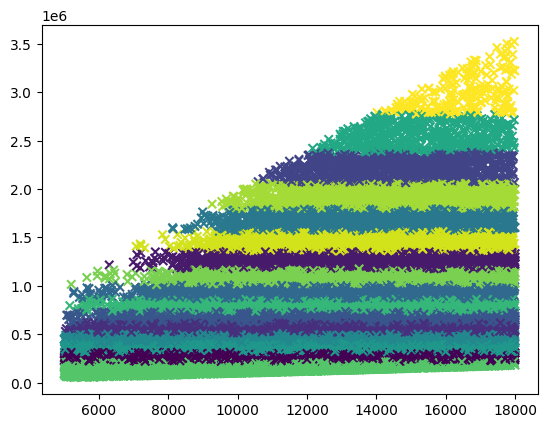

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
# composing data set
data = np.array(df_apart_paris[['price_in_m_2_scaled','Valeur_fonciere_scaled']])
# kmeans model, setting k = 3
km = KMeans(n_clusters = 16,n_init="auto")
clusters=km.fit_predict(data)
# plotting data set
plt.scatter(*zip(*data),c=clusters,marker = "x")

In [75]:
km.cluster_centers_.shape


(3, 2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
# composing data set
data  = df_apart_paris[['Surface reelle bati','Code postal']]#,'No voie','Voie','Nombre de lots','Nombre pieces principales','surface_des_lots','Valeur_fonciere_scaled']]
# kmeans model, setting k = 3
km = KMeans(n_clusters = 3,n_init="auto")
clusters=km.fit_predict(data)
km.cluster_centers_
# plotting data set
plt.scatter(*zip(*data),c=clusters,marker = "x")

__Train a Random Forest model__ 

In [101]:
# Splitting the dataset into training and testing set (80/20)
X, X_test, y, y_test = train_test_split(df_apart_paris[['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']] , df_apart_paris['Valeur_fonciere_scaled'], test_size = 0.2, random_state = 28)
# Splitting the dataset into training and testing set (80/20)
X_train, X_valid, y_train, y_validation = train_test_split(X,y, test_size = 0.2, random_state = 28)

In [102]:
#random forest

# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators=40,max_features=4,min_samples_leaf=8, random_state = 0,max_samples=0.2)

# Fitting the Random Forest Regression model to the data
model.fit(X, y) 

# Predicting the target values of the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X)

In [53]:
k=[2,4,8,16,32,64,128,256,512]
for i in k :
    # Initializing the Random Forest Regression model with 10 decision trees
    model = RandomForestRegressor(n_estimators=40,max_features=4,min_samples_leaf=i, random_state = 0,max_samples=0.2)

    # Fitting the Random Forest Regression model to the data
    model.fit(X, y) 

    # Predicting the target values of the test set
    y_pred = model.predict(X_test)
    y_pred_train=model.predict(X)
    score = r2_score(y_test, y_pred)
    score_train=r2_score(y, y_pred_train)
    rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
    explained_variance_scor=explained_variance_score(y_test, y_pred)
    max_err=max_error(y_test, y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    mae_train=mean_absolute_error(y, y_pred_train)
    residuals=abs(y_pred-y_test)
    # Calculate percentage errors
    pct_errors = (residuals / y_test) * 100
    # Calculate the mean of the percentage errors
    mean_pct_error = pct_errors.mean()
    print(f'this with using {i} of the data ')
    print(f"The mean percentage error for all apartments is {mean_pct_error:.2f}%")
    print(f'the r2 score is: {score} while the r2 score on the training data is: {score_train}')
    print(f'the mean_absolute_error is: {mae} while the mean_absolute_error on the training data is: {mae_train}',"the maximum error is:",max_err)


this with using 2 of the data 
The mean percentage error for all apartments is 13.88%
the r2 score is: 0.9216216717406924 while the r2 score on the training data is: 0.9425702227060163
the mean_absolute_error is: 75301.90715686337 while the mean_absolute_error on the training data is: 64774.95698616405 the maximum error is: 1317578.2128844075
this with using 4 of the data 
The mean percentage error for all apartments is 13.97%
the r2 score is: 0.9202761246391911 while the r2 score on the training data is: 0.9351357146435199
the mean_absolute_error is: 75875.46232923339 while the mean_absolute_error on the training data is: 69033.29237325568 the maximum error is: 1401153.02113636
this with using 8 of the data 
The mean percentage error for all apartments is 14.09%
the r2 score is: 0.9197632922905037 while the r2 score on the training data is: 0.9285190596271682
the mean_absolute_error is: 76436.01540953621 while the mean_absolute_error on the training data is: 72733.5327320788 the maxim

In [103]:
#scoring
score = r2_score(y_test, y_pred)
score_train=r2_score(y, y_pred_train)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
explained_variance_scor=explained_variance_score(y_test, y_pred)
max_err=max_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
mae_train=mean_absolute_error(y, y_pred_train)
residuals=abs(y_pred-y_test)
# Calculate percentage errors
pct_errors = (residuals / y_test) * 100
# Calculate the mean of the percentage errors
mean_pct_error = pct_errors.mean()

print(f"The mean percentage error for all apartments is {mean_pct_error:.2f}%")


print(f'the r2 score is: {score} while the r2 score on the training data is: {score_train}')
print("RMSE:",rmse)
print("explained_variance_scor: ",explained_variance_scor)
print(f'the mean_absolute_error is: {mae} while the mean_absolute_error on the training data is: {mae_train}')
print("the maximum error is:",max_err)

The mean percentage error for all apartments is 16.05%
the r2 score is: 0.9046425862882803 while the r2 score on the training data is: 0.9152586190084521
RMSE: 131043.094
explained_variance_scor:  0.9046426220406381
the mean_absolute_error is: 84867.1019476257 while the mean_absolute_error on the training data is: 80961.14301990134
the maximum error is: 1307806.0148978054


In [137]:
residuals

2217      42242.676688 
166158    51166.387045 
59826     62246.707156 
162996    95382.068741 
99053     36330.226474 
              ...      
158127    101393.200230
153291    27816.071391 
131192    31287.238347 
144161    44254.630837 
133771    52384.870680 
Name: Valeur_fonciere_scaled, Length: 24851, dtype: float64

<Axes: >

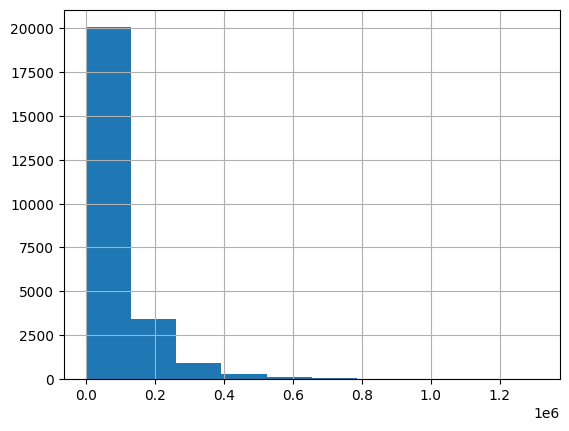

In [139]:

residuals.hist()

# Global interpretability

array([0.72756022, 0.03277412, 0.00856907, 0.00940882, 0.00308646,
       0.21860131])

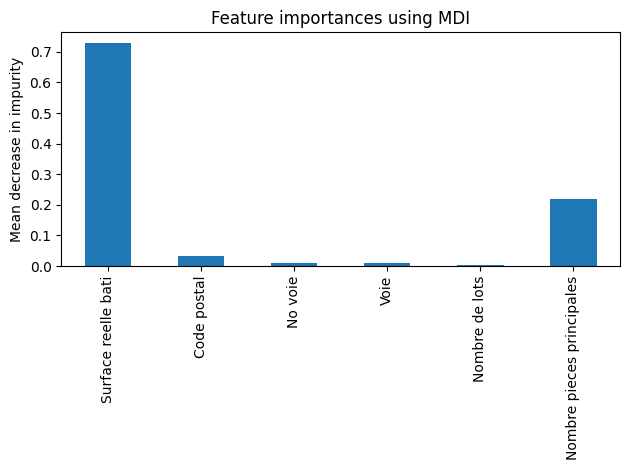

In [104]:
importances= model.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
importances


# Local interpretability
we take a sample where the error was to high and another where the error was low and study which variable affect the model most

In [128]:
pct_errors[(pct_errors>150)]

78475     170.774430
174247    159.658959
176663    156.594583
175529    152.187542
110458    154.153625
79162     153.104206
107506    163.276842
84091     150.465202
104924    155.483463
Name: Valeur_fonciere_scaled, dtype: float64

In [121]:
df_apart_paris[(df_apart_paris.index==179846)]

,No disposition,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Code commune,Section,No plan,Nombre de lots,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,surface_des_lots,year,month,Season,Valeur_fonciere_scaled,price_in_m_2,price_in_m_2_scaled
179846,1,2022-01-27,425000.0,7.0,16.0,849.0,75019.0,119,12.0,36,2,45.0,2.0,0.0,0.0,0.0,44.98,2022,1,0.0,430100.0,9444.444444,9557.777778


In [133]:
samples

,Surface reelle bati,Code postal,No voie,Voie,Nombre de lots,Nombre pieces principales
0,-0.887951,-0.708148,-0.278834,0.259745,-0.466191,-1.023099
1,-1.440122,0.672886,0.381795,0.035127,-1.027051,-0.670139
2,-0.477736,0.452537,0.541719,-0.287463,-0.792167,-1.540288
3,-1.227746,0.287029,-0.857920,0.668640,-1.436255,-0.226258
4,-0.891092,0.790061,0.103077,0.051206,-1.147492,-0.940623
...,...,...,...,...,...,...
19995,-1.347546,0.187949,-0.932106,-0.126548,-1.496787,-1.231523
19996,-0.707511,0.351246,-0.072484,0.384989,-1.555480,-1.864006
19997,-1.491829,0.301675,-0.114212,0.640508,-1.081088,-0.460476
19998,-2.070898,1.257503,-0.014449,0.481960,-0.881155,-0.867462


-169.08144575655578
[  1.55190836 -39.61706596 -38.32269702 -17.65686304 -23.42699004
 139.01140561]


<BarContainer object of 6 artists>

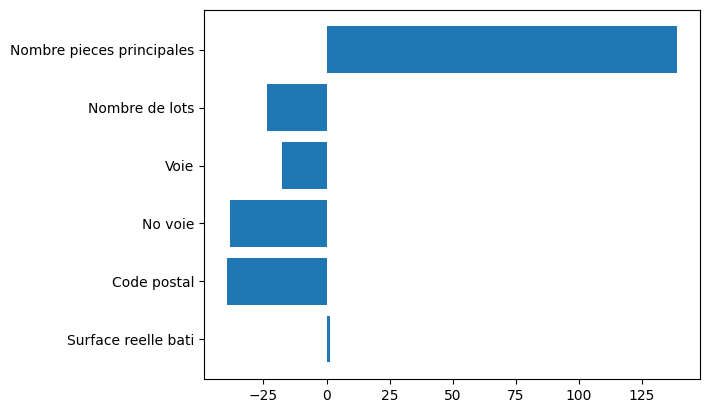

In [126]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_apart_paris[['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
df_apart_paris_scaled=scaler.transform(df_apart_paris[['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
sample=scaler.transform(df_apart_paris[(df_apart_paris.index==179846)][['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
sample=pd.DataFrame(sample, columns = scaler.feature_names_in_)

# x is my training data
# mu is the mean
# std is the standard deviation

def gaussian_noise(x,std,k,mu=0):
    samples=[]
    for i in range(k):
        noise = np.random.normal(0, std, size = x.shape)
        x_noisy = x + noise
        samples.append(x_noisy)
    return pd.concat(samples,ignore_index=True)
samples=gaussian_noise(sample,0.5,20000)
samples

from sklearn import linear_model

X_trainl, X_testl, y_trainl, y_testl = train_test_split(samples,  model.predict(samples),test_size = 0.33, random_state = 28)
lasso = linear_model.Lasso(alpha=0.0001)
lasso.fit(X_trainl,y_trainl)
y_predl = lasso.predict(X_testl)
score = r2_score(y_predl, y_testl)
print(score)
print(lasso.coef_)

plt.barh(X_trainl.columns,lasso.coef_)

In [123]:
df_apart_paris[(df_apart_paris.index==179386)]

,No disposition,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Code commune,Section,No plan,Nombre de lots,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,surface_des_lots,year,month,Season,Valeur_fonciere_scaled,price_in_m_2,price_in_m_2_scaled
179386,1,2022-01-24,375400.0,3.0,12.0,2627.0,75018.0,118,49.0,21,2,54.0,2.0,0.0,0.0,0.0,42.81,2022,1,0.0,379904.8,6951.851852,7035.274074


-879.3882520072161
[  3.89651028  10.40849102  -6.32609735  13.01027265 -16.35004418
  61.61063816]


<BarContainer object of 6 artists>

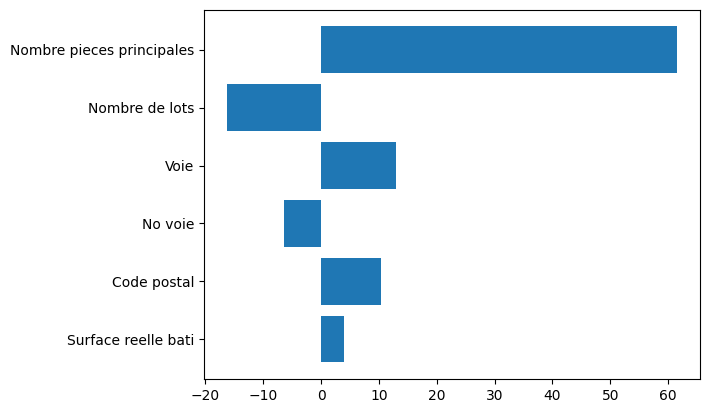

In [127]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_apart_paris[['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
df_apart_paris_scaled=scaler.transform(df_apart_paris[['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
sample=scaler.transform(df_apart_paris[(df_apart_paris.index==179386)][['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
sample=pd.DataFrame(sample, columns = scaler.feature_names_in_)

# x is my training data
# mu is the mean
# std is the standard deviation

def gaussian_noise(x,std,k,mu=0):
    samples=[]
    for i in range(k):
        noise = np.random.normal(0, std, size = x.shape)
        x_noisy = x + noise
        samples.append(x_noisy)
    return pd.concat(samples,ignore_index=True)
samples=gaussian_noise(sample,0.5,20000)
samples

from sklearn import linear_model

X_trainl, X_testl, y_trainl, y_testl = train_test_split(samples,  model.predict(samples),test_size = 0.33, random_state = 28)
lasso = linear_model.Lasso(alpha=0.0001)
lasso.fit(X_trainl,y_trainl)
y_predl = lasso.predict(X_testl)
score = r2_score(y_predl, y_testl)
print(score)
print(lasso.coef_)

plt.barh(X_trainl.columns,lasso.coef_)

In [129]:
df_apart_paris[(df_apart_paris.index==174247)]

,No disposition,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Code commune,Section,No plan,Nombre de lots,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,surface_des_lots,year,month,Season,Valeur_fonciere_scaled,price_in_m_2,price_in_m_2_scaled
174247,1,2021-12-07,310000.0,11.0,18.0,3131.0,75002.0,102,5.0,111,2,63.0,2.0,0.0,0.0,0.0,37.96,2021,12,3.0,317483.4,4920.634921,5039.419048


-206.59658854046617
[2.88575205e-02 1.48414011e-01 1.73373873e+00 2.37433611e-01
 3.53623977e-01 1.00173085e-03]


<BarContainer object of 6 artists>

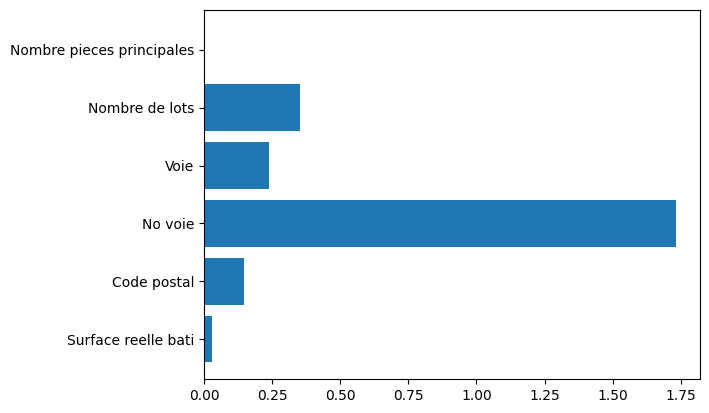

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_apart_paris[['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
df_apart_paris_scaled=scaler.transform(df_apart_paris[['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
sample=scaler.transform(df_apart_paris[(df_apart_paris.index==92448)][['Surface reelle bati','Code postal','No voie','Voie','Nombre de lots','Nombre pieces principales']])
sample=pd.DataFrame(sample, columns = scaler.feature_names_in_)

# x is my training data
# mu is the mean
# std is the standard deviation

def gaussian_noise(x,std,k,mu=0):
    samples=[]
    for i in range(k):
        noise = np.random.normal(0, std, size = x.shape)
        x_noisy = x + noise
        samples.append(x_noisy)
    return pd.concat(samples,ignore_index=True)
samples=gaussian_noise(sample,0.5,20000)
samples

from sklearn import linear_model

X_trainl, X_testl, y_trainl, y_testl = train_test_split(samples,  model.predict(samples),test_size = 0.33, random_state = 28)
lasso = linear_model.Lasso(alpha=0.0001)
lasso.fit(X_trainl,y_trainl)
y_predl = lasso.predict(X_testl)
score = r2_score(y_predl, y_testl)
print(score)
print(lasso.coef_)

plt.barh(X_trainl.columns,lasso.coef_)

the predictions are getting bad with the price getting high!
we can see that we have some noisy data where the price is too high where the price is too high, we should go back to
the data and fix this.


# Pickling The Model file For Deployment

In [140]:
import pickle

In [141]:
pickle.dump(model,open('model.pkl','wb'))


In [ ]:
pickled_model=pickle.load(open('model.pkl','rb'))


C:\Users\khale\anaconda3\envs\house_prediction\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\khale\anaconda3\envs\house_prediction\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
request={
    "data":{
    "Surface reelle bati":20,
    "Code postal":75101.0
    }
}

In [ ]:
pd.json_normalize(request['data'])

,Surface reelle bati,Code postal
0,20,75101.0


In [ ]:
pickled_model.predict(pd.json_normalize(request['data']))


array([208780.99203308])

In [ ]:
pickled_model.predict(np.array(list(request['data'].values())).reshape(1,-1))[0]

C:\Users\khale\anaconda3\envs\house_prediction\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


288682.3486531472

In [ ]:
importances= model.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

NameError: name 'X' is not defined

Stacking is a machine learning ensemble technique that involves combining the predictions from multiple models to improve the overall performance of the model. In stacking, the predictions from multiple models are combined using a meta-model, which learns to weigh the predictions from each model to produce a final prediction.

The basic idea of stacking is to train several models using the same training data, but each model may have a different algorithm, hyperparameters, or features. Then, the predictions from these models are used as input features to a meta-model, which is trained on a validation set. The meta-model learns to combine the predictions from each model in a way that optimizes the performance on the validation set. Once the meta-model is trained, it can be used to make predictions on new data.

The benefits of stacking are that it can improve the performance of the model by combining the strengths of multiple models, and it can reduce the risk of overfitting by using a separate validation set to train the meta-model. However, stacking can also be computationally expensive, and it requires careful tuning of the models and the meta-model to optimize the performance.

Stacking can be used in a variety of machine learning problems, such as regression, classification, and ranking. It is often used in competitions and real-world applications where high accuracy is required.